# Screw Anomalies Autoencoder

## about Unsupervised Anomaly Detection
Unsupervised anomaly detection is a type of machine learning algorithm that aims to identify anomalies or outliers in a dataset without any prior knowledge of what constitutes an anomaly. In contrast to supervised anomaly detection, which requires labeled data with examples of both normal and anomalous behavior, unsupervised anomaly detection algorithms work on unlabeled data, making them useful in situations where labeled data is scarce or unavailable.

There are several techniques for unsupervised anomaly detection, including statistical methods, clustering algorithms, and deep learning approaches. Statistical methods involve modeling the normal behavior of the data and identifying points that deviate significantly from this model as anomalies. Clustering algorithms group data points into clusters based on their similarity and identify points that fall outside of any cluster as anomalies. Deep learning approaches use neural networks to learn the underlying patterns in the data and identify anomalies based on their deviation from these patterns.

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt

## Train data of 1 class and Test data of several classes
One-class classification can be useful in situations where there is limited data available for some classes or where the data is imbalanced. For example, in anomaly detection, the goal is to identify rare instances that do not conform to the normal behavior of the system. In such cases, it may be difficult to collect a large number of anomalous instances for training, and one-class classification can be used to identify anomalies based on their deviation from the normal behavior.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Image preprocessing
transform = transforms.Compose([
    transforms.Resize((224,224)), # Unify images to (224,224) size
    transforms.ToTensor()
])

train_dir='screw_data/train'
test_dir='screw_data/test'

train_dataset = ImageFolder(root=train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = ImageFolder(root=test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
class_names = test_dataset.classes
print(class_names)

['good', 'manipulated_front', 'scratch_head', 'scratch_neck', 'thread_side', 'thread_top']


## about Autoencoder
Deep learning methods, such as autoencoders or variational autoencoders (VAEs), can also be used for one-class classification. In this approach, the model is trained to reconstruct the input data for the single class, and anomalies are identified by measuring the difference between the input data and the reconstructed output. Once the model is trained, it can be used to identify anomalies in new data points from multiple classes.

In [3]:
# Autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(8, 4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [4]:
# Instantiate Autoencoder and send to GPU
autoencoder = Autoencoder().to(device)

# Definition of loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

## train the autoencoder
To train the autoencoder, you can use PyTorch's built-in loss functions, such as the mean squared error (MSE) loss, to measure the difference between the input and output data. The autoencoder can be trained using stochastic gradient descent (SGD) or other optimization algorithms. Once the autoencoder is trained on normal data, you can use it to identify anomalies by comparing the reconstruction error of new data points to a threshold value.

In [5]:
# training
for epoch in range(100):
    running_loss = 0.0
    for data in train_loader:
        img, _ = data
        img = Variable(img).to(device)
        optimizer.zero_grad()
        outputs = autoencoder(img)
        loss = criterion(outputs, img)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print('Epoch [%d], Loss: %.4f' % (epoch+1, running_loss/len(train_loader)))

# test
autoencoder.eval()
test_loss = 0.0
with torch.no_grad():
    for data in test_loader:
        img, _ = data
        img = Variable(img).to(device)
        outputs = autoencoder(img)
        loss = criterion(outputs, img)
        test_loss += loss.item()

print('Test Loss: %.4f' % (test_loss/len(test_loader)))

Epoch [1], Loss: 0.3623
Epoch [2], Loss: 0.3065
Epoch [3], Loss: 0.1884
Epoch [4], Loss: 0.0653
Epoch [5], Loss: 0.0238
Epoch [6], Loss: 0.0143
Epoch [7], Loss: 0.0109
Epoch [8], Loss: 0.0094
Epoch [9], Loss: 0.0084
Epoch [10], Loss: 0.0076
Epoch [11], Loss: 0.0069
Epoch [12], Loss: 0.0062
Epoch [13], Loss: 0.0055
Epoch [14], Loss: 0.0048
Epoch [15], Loss: 0.0040
Epoch [16], Loss: 0.0034
Epoch [17], Loss: 0.0029
Epoch [18], Loss: 0.0025
Epoch [19], Loss: 0.0023
Epoch [20], Loss: 0.0022
Epoch [21], Loss: 0.0021
Epoch [22], Loss: 0.0021
Epoch [23], Loss: 0.0020
Epoch [24], Loss: 0.0019
Epoch [25], Loss: 0.0019
Epoch [26], Loss: 0.0019
Epoch [27], Loss: 0.0018
Epoch [28], Loss: 0.0018
Epoch [29], Loss: 0.0017
Epoch [30], Loss: 0.0017
Epoch [31], Loss: 0.0017
Epoch [32], Loss: 0.0017
Epoch [33], Loss: 0.0016
Epoch [34], Loss: 0.0016
Epoch [35], Loss: 0.0016
Epoch [36], Loss: 0.0016
Epoch [37], Loss: 0.0016
Epoch [38], Loss: 0.0016
Epoch [39], Loss: 0.0015
Epoch [40], Loss: 0.0014
Epoch [41

In [6]:
#### comparison bertween classes in test data
autoencoder.eval()
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
class_encodings = [[] for i in range(6)]
with torch.no_grad():
    for data in test_loader:
        img, label = data
        img = Variable(img).to(device)
        encoding = autoencoder.encoder(img)
        class_encodings[label.item()].append(encoding.cpu().numpy().ravel())

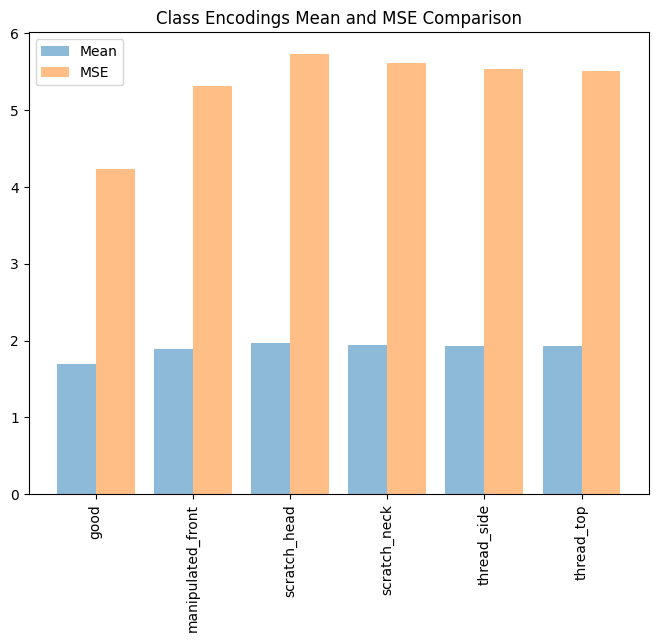

In [7]:
class_means = []
class_mses = []
for i in range(6):
    class_means.append(np.mean(class_encodings[i]))
    class_mse = np.mean((class_encodings[i] - class_means[i])**2)
    class_mses.append(class_mse)

plt.figure(figsize=(8, 6))
plt.bar(np.arange(6)-0.2, class_means, width=0.4, label='Mean', alpha=0.5)
plt.bar(np.arange(6)+0.2, class_mses, width=0.4, label='MSE', alpha=0.5)
plt.xticks(range(6), class_names, rotation=90)
plt.legend()
plt.title("Class Encodings Mean and MSE Comparison")
plt.show()